In [1]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import eval_unlooped_model, aggregate_metrics, eval_looped_model


In [2]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [3]:
import matplotlib.pyplot as plt
import matplotlib

def plot_errs(result_errs_agg):
    fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

    err_result_dict_agg = result_errs_agg
    
    cmap = matplotlib.cm.get_cmap("coolwarm")
    # result_name_list = ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Looped Transformer']  # , 
    result_name_list = list(result_errs_agg.keys())
    colors = cmap(np.linspace(0, 1, len(result_name_list)))
    for idx, model_name in enumerate(result_name_list):
        err = err_result_dict_agg[model_name]["mean"]
        ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
        low = err_result_dict_agg[model_name]["bootstrap_low"]
        high = err_result_dict_agg[model_name]["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])
    
    ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
    ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
    # ax.set_ylim(-0.1, 2)
    # plt.xticks(np.arange(0, n_points))
    plt.rc('font', family='serif')
    ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
    y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])
    
    # plt.savefig("result_folder/Figures/LR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')

In [4]:
device = torch.device('cuda:2')

In [5]:
def get_model(model, result_dir, run_id, step, best=False):
    if best:
        model_path = os.path.join(result_dir, run_id, 'model_best.pt')
        state_dict = torch.load(model_path, map_location='cpu')['state_dict']
        best_err = torch.load(model_path, map_location='cpu')['loss']
        print("saved model with loss:", best_err)
    if step == -1:
        model_path = os.path.join(result_dir, run_id, 'state.pt')
        state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']
    else:
        model_path = os.path.join(result_dir, run_id, 'model_{}.pt'.format(step))
        state_dict = torch.load(model_path, map_location='cpu')['model']

#     return state_dict
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=True)
    
    return model


## Get dataset

In [6]:
class LinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(LinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims, device=device)  # [B, n, d]
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1, device=device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b
        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 20

real_task = LinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

## load unlooped model

In [7]:
result_dir = '../results2/linear_regression_baseline'
run_id = '0730153647-LR_baseline-43dc'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err_default_transformer, y_pred_total = eval_unlooped_model(model, xs, ys)

number of parameters: 9.48M


In [8]:
result_errs = {}
result_errs['Transformer'] = err_default_transformer

## Load looped transformer with optimal b

In [9]:
from models import TransformerModelLooped

result_dir = '../results2/linear_regression_loop'

runs = {
        # "Default looped": {"run_id": "0803162115-LR_loop_L1_ends{30}_T{15}-91e3", "n_layer": 1}, \
        # "Default looped (2)": {"run_id": "0731160704-LR_loop_L3_ends{30}_T{15}-764c", "n_layer": 1, "step": 70000}, \
        # "Looped, N=11": {"run_id": "0730183917-LR_loop_L1_ends{30}_T{15}_N{11}-08ea", "n_layer": 1, "n_tokens": 11}, \
        # "Looped, N=-1": {"run_id": "0730200924-LR_loop_L1_ends{30}_T{15}_N{-1}-3aec", "n_layer": 1}, \
        # "Looped, N=-1 (2)": {"run_id": "0731110508-LR_loop_L1_ends{30}_T{15}_N{-1}-ebcd", "n_layer": 1}, \
        # "Looped, N=-5": {"run_id": "0805015441-LR_loop_L1_ends{30}_T{15}_N{-5}-c40c", "n_layer": 1, "n_tokens": -5}, \
        # "Looped, N=-3": {"run_id": "0805015100-LR_loop_L1_ends{30}_T{15}_N{-3}-2d39", "n_layer": 1, "n_tokens": -3}, \
        # "Looped, N=-7": {"run_id": "0805012749-LR_loop_L1_ends{30}_T{15}_N{-7}-f037", "n_layer": 1, "n_tokens": -7}, \
        # "Looped, N=-10": {"run_id": "0805012838-LR_loop_L1_ends{30}_T{15}_N{-10}-9a65", "n_layer": 1, "n_tokens": -10}, \
        # "Looped, N=0.7": {"run_id": "0805013143-LR_loop_L1_ends{30}_T{15}_N{0.7}-3fdf", "n_layer": 1, "n_tokens": 0.7}, \
        # "Looped, N=-3": {"run_id": "0801162621-LR_loop_L2_ends{30}_T{15}_N{-3}-d0d5", "n_layer": 1}, \
        # "Looped, N=-4": {"run_id": "0801190515-LR_loop_L1_ends{30}_T{15}_N{-4}-4dc0", "n_layer": 1, "n_tokens": -4}, \
        # "Looped, N=-2": {"run_id": "0801140357-LR_loop_L1_ends{30}_T{15}_N{-2}-0f77", "n_layer": 1, "n_tokens": -2}, \
        # "Looped, N=0.5": {"run_id": "0731012201-LR_loop_L1_ends{30}_T{15}_N{0.5}-aa1f", "n_layer": 1, "n_tokens": 0.5}, \
        # "Looped, N=0.9": {"run_id": "0731105704-LR_loop_L1_ends{30}_T{15}_N{0.9}-ac48", "n_layer": 1, "n_tokens": 0.9}, \
        # "Looped, L=2": {"run_id": "0731164711-LR_loop_L2_ends{30}_T{15}-d083", "n_layer": 2, "step": 70000}, \
        # "Looped, L=2 (2)": {"run_id": "0803162021-LR_loop_L2_ends{30}_T{15}-7ecd", "n_layer": 2, "step": 70000}, \
        "Looped, ssm": {"run_id": "0803131927-LR_loop_L1_ends{30}_T{15}_ssm-ebc7", "n_layer": 1, "use_ssm": True}, \
        # "Looped, L=3": {"run_id": "0731142820-LR_loop_L3_ends{30}_T{15}-9d9e", "n_layer": 3}, \
        # "Looped, L=4": {"run_id": "0804163507-LR_loop_L4_ends{30}_T{15}-0f3b", "n_layer": 4, "step": 70000}, \
        # "Looped, L=4, feed": {"run_id": "0804163530-LR_loop_L4_ends{30}_T{15}_feed-c3c5", "feed_block": True, "n_layer": 4, "step": 70000}, \
        # "Looped, L=2, N=-3": {"run_id": "0804163713-LR_loop_L2_ends{30}_T{15}_N{-3}-b580", "n_tokens": -3, "n_layer": 2, "step": 70000}, \
        # "Looped, L=2, feed": {"run_id": "0801140714-LR_loop_L2_ends{30}_T{15}_feed-431f", "n_layer": 2, "step": 70000, "feed_block": True}, \
        # "Looped, L=2, feed (2)": {"run_id": "0803162000-LR_loop_L2_ends{30}_T{15}_feed-030b", "n_layer": 2, "step": 75000, "feed_block": True}, \
        # "Looped, L=2, feed, 50k": {"run_id": "0801003556-LR_loop_L2_ends{30}_T{15}_feed-487d", "n_layer": 2, "step": 50000}, \
        # "Looped, L=2, feed, 70k": {"run_id": "0801003556-LR_loop_L2_ends{30}_T{15}_feed-487d", "n_layer": 2, "step": 70000},
       }

n_positions = 101
n_embd = 256
n_head = 8
T = 500

for run in tqdm(runs.keys()):
    use_ssm = False
    if "use_ssm" in runs[run].keys():
        use_ssm = runs[run]["use_ssm"]
    feed_block = False
    if "feed_block" in runs[run].keys():
        feed_block = runs[run]["feed_block"]
    n_tokens = 0
    if "n_tokens" in runs[run].keys():
        n_tokens = runs[run]["n_tokens"]
    model = TransformerModelLooped(n_dims, n_positions, n_embd, runs[run]["n_layer"], n_head, use_ssm=use_ssm, save_n_tokens=n_tokens, \
                                   feed_block=feed_block)
    step = -1
    if "step" in runs[run].keys():
        step = runs[run]["step"]
    model = get_model(model, result_dir, runs[run]["run_id"], step)
    model = model.to(device)
        
    err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)
    
    result_errs[run] = err

  0%|                                                                                                                                   | 0/1 [00:00<?, ?it/s]


number of parameters: 0.71M


RuntimeError: Error(s) in loading state_dict for TransformerModelLooped:
	size mismatch for _backbone.transformer.h.0.ssm.deltaBC_layer.weight: copying a param with shape torch.Size([144, 256]) from checkpoint, the shape in current model is torch.Size([384, 256]).
	size mismatch for _backbone.transformer.h.0.ssm.dt_proj_layer.weight: copying a param with shape torch.Size([256, 16]) from checkpoint, the shape in current model is torch.Size([256, 256]).

In [169]:
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)

In [170]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Looped, ssm'])

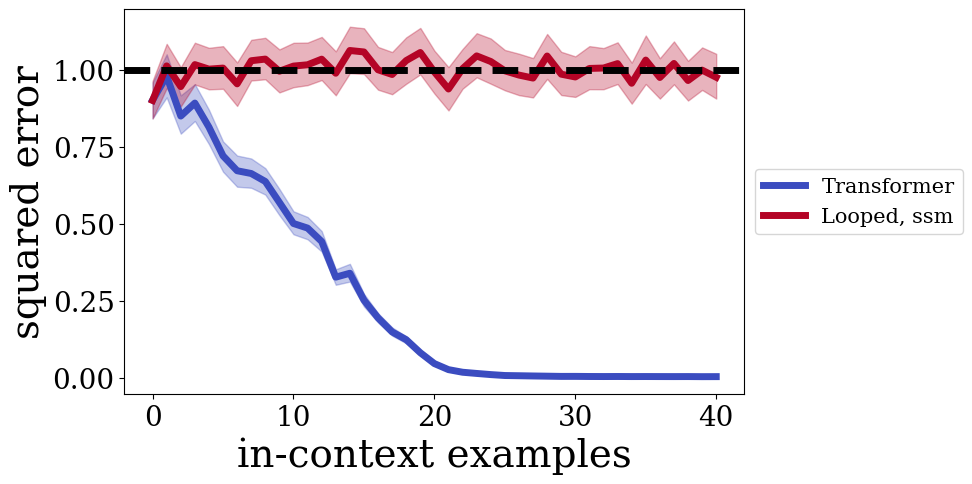

In [171]:
plot_errs(result_errs_agg)

### Also get the "weak" baseline

In [121]:
from utils import get_relevant_baselines

baselines = get_relevant_baselines("linear_regression")
for baseline_model in baselines:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [122]:
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)

### All the methods together

In [123]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Default looped', 'Looped, N=11', 'Looped, N=-1', 'Looped, N=-5', 'Least Squares', '3-Nearest Neighbors', 'Averaging'])

/tmp/ipykernel_4003840/3373505048.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("coolwarm")


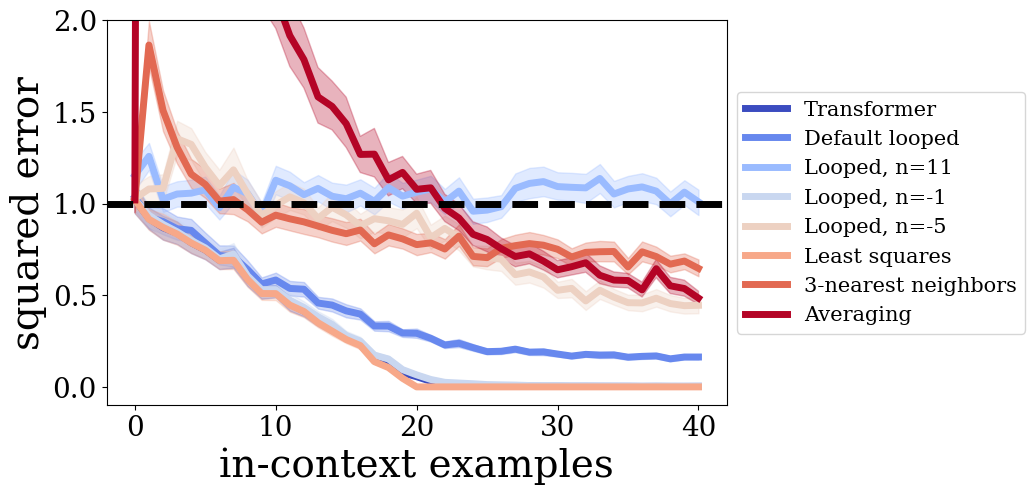

In [124]:
plot_errs(result_errs_agg)